<a href="https://colab.research.google.com/github/Rishabhjuneja/NYC-Taxi/blob/main/exploartion_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [13]:
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from datetime import datetime
from sklearn.cluster import MiniBatchKMeans, KMeans
import warnings
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import time
import folium
from folium import Choropleth ,  Circle, Marker

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [21]:
file_loc='./green_tripdata_2016-02.csv'
taxi_data = spark.read.csv(file_loc, inferSchema=True, header =True)

In [6]:
dtaxi_data.show(5)

+--------+--------------------+---------------------+------------------+----------+------------------+------------------+------------------+------------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+----------+
|VendorID|lpep_pickup_datetime|Lpep_dropoff_datetime|Store_and_fwd_flag|RateCodeID|  Pickup_longitude|   Pickup_latitude| Dropoff_longitude|  Dropoff_latitude|Passenger_count|Trip_distance|Fare_amount|Extra|MTA_tax|Tip_amount|Tolls_amount|Ehail_fee|improvement_surcharge|Total_amount|Payment_type|Trip_type |
+--------+--------------------+---------------------+------------------+----------+------------------+------------------+------------------+------------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+----------+
|       2| 2016-02-01 00:00:01|  2016-02-01 00:10:06|                 N| 

In [7]:
dtaxi_data.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- lpep_pickup_datetime: string (nullable = true)
 |-- Lpep_dropoff_datetime: string (nullable = true)
 |-- Store_and_fwd_flag: string (nullable = true)
 |-- RateCodeID: integer (nullable = true)
 |-- Pickup_longitude: double (nullable = true)
 |-- Pickup_latitude: double (nullable = true)
 |-- Dropoff_longitude: double (nullable = true)
 |-- Dropoff_latitude: double (nullable = true)
 |-- Passenger_count: integer (nullable = true)
 |-- Trip_distance: double (nullable = true)
 |-- Fare_amount: double (nullable = true)
 |-- Extra: double (nullable = true)
 |-- MTA_tax: double (nullable = true)
 |-- Tip_amount: double (nullable = true)
 |-- Tolls_amount: double (nullable = true)
 |-- Ehail_fee: string (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- Total_amount: double (nullable = true)
 |-- Payment_type: integer (nullable = true)
 |-- Trip_type : integer (nullable = true)



In [7]:
# check number of rows & Coloums 

print((taxi_data.count(), len(taxi_data.columns)))

(452861, 21)


In [8]:
# Check any missing values 

from pyspark.sql.functions import lit

rows = taxi_data.count()
summary = taxi_data.describe().filter(F.col("summary") == "count")
summary.select(*((F.lit(rows)-F.col(c)).alias(c) for c in taxi_data.columns)).show()

+--------+--------------------+---------------------+------------------+----------+----------------+---------------+-----------------+----------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+----------+
|VendorID|lpep_pickup_datetime|Lpep_dropoff_datetime|Store_and_fwd_flag|RateCodeID|Pickup_longitude|Pickup_latitude|Dropoff_longitude|Dropoff_latitude|Passenger_count|Trip_distance|Fare_amount|Extra|MTA_tax|Tip_amount|Tolls_amount|Ehail_fee|improvement_surcharge|Total_amount|Payment_type|Trip_type |
+--------+--------------------+---------------------+------------------+----------+----------------+---------------+-----------------+----------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+----------+
|     0.0|                 0.0|                  0.0|               0.0|       0.0|             0

In [9]:
# Descriptive Statistics

taxi_data.describe().show()
 

+-------+-------------------+--------------------+---------------------+------------------+------------------+-------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+-------------------+-------------------+------------------+-------------------+---------+---------------------+------------------+------------------+-------------------+
|summary|           VendorID|lpep_pickup_datetime|Lpep_dropoff_datetime|Store_and_fwd_flag|        RateCodeID|   Pickup_longitude|   Pickup_latitude|  Dropoff_longitude|  Dropoff_latitude|  Passenger_count|     Trip_distance|       Fare_amount|              Extra|            MTA_tax|        Tip_amount|       Tolls_amount|Ehail_fee|improvement_surcharge|      Total_amount|      Payment_type|         Trip_type |
+-------+-------------------+--------------------+---------------------+------------------+------------------+-------------------+------------------+-------------------+---

Study: There seems to be outliers in differenet coloums such as ratecodeid , trip distance , fare amount, extra , mat tax should be .5 , trip amount , 

In [25]:
# Check quantile to deepdive check for outliers
pandastaxi_data = taxi_data.toPandas()
pandastaxi_data.quantile(q=0.5, axis=0, numeric_only=True, interpolation='linear')

VendorID                  2.000000
RateCodeID                1.000000
Pickup_longitude        -73.946976
Pickup_latitude          40.746689
Dropoff_longitude       -73.946152
Dropoff_latitude         40.747276
Passenger_count           1.000000
Trip_distance             1.800000
Fare_amount               9.000000
Extra                     0.500000
MTA_tax                   0.500000
Tip_amount                0.000000
Tolls_amount              0.000000
improvement_surcharge     0.300000
Total_amount             11.000000
Payment_type              1.000000
Trip_type                 1.000000
Name: 0.5, dtype: float64

In [130]:
# Remove data with outliers

taxi_data_no_outlier=taxi_data.where("RateCodeID < 7").where("Trip_distance < 1.8").where("Fare_amount between 0.1 and 9").where("MTA_tax  = 0.5").where("Tip_amount between 0 and 5").where("Extra between 0 and 1").where("Tolls_amount = 0").where("improvement_surcharge = 0.3").where("Total_amount between 0 and 11")


print((taxi_data_no_outlier.count(), len(taxi_data_no_outlier.columns)))


(198794, 21)


I would have looked at outlier for lat and long as well 

In [131]:
# get date and time coloum seprately for pickup and drop
from pyspark.sql import functions as F

split_col = F.split(taxi_data_no_outlier['lpep_pickup_datetime'], ' ')
split_col2 = F.split(taxi_data_no_outlier['Lpep_dropoff_datetime'], ' ')
taxi_data_no_outlier = taxi_data_no_outlier.withColumn('pickup_date', split_col.getItem(0)).withColumn('pickup_time', split_col.getItem(1)).withColumn('drop_date', split_col2.getItem(0)).withColumn('drop_time', split_col2.getItem(1))


taxi_data_no_outlier.show(5)

+--------+--------------------+---------------------+------------------+----------+------------------+------------------+------------------+------------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+----------+-----------+-----------+----------+---------+
|VendorID|lpep_pickup_datetime|Lpep_dropoff_datetime|Store_and_fwd_flag|RateCodeID|  Pickup_longitude|   Pickup_latitude| Dropoff_longitude|  Dropoff_latitude|Passenger_count|Trip_distance|Fare_amount|Extra|MTA_tax|Tip_amount|Tolls_amount|Ehail_fee|improvement_surcharge|Total_amount|Payment_type|Trip_type |pickup_date|pickup_time| drop_date|drop_time|
+--------+--------------------+---------------------+------------------+----------+------------------+------------------+------------------+------------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+--------

In [10]:
pandastaxi_data = taxi_data.toPandas()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


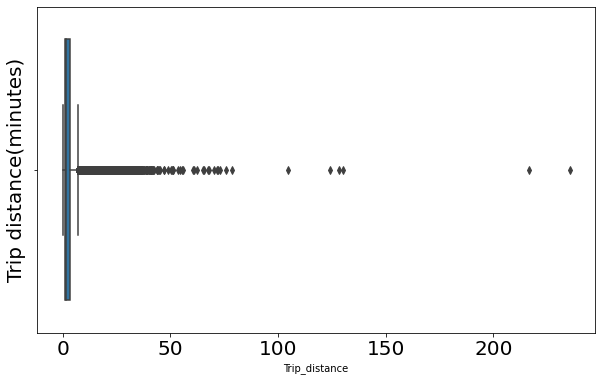

In [16]:
# Plot trip distance to check outliers
plt.figure(figsize = (10,6))
sns.boxplot("Trip_distance", data = pandastaxi_data, orient = "v")
plt.tick_params(labelsize = 20)
plt.ylabel("Trip distance(minutes)", fontsize = 20)
plt.show()

Study: There are some outliers but we should be looked deep into it

In [17]:
# We investigate Quartiles (0-100)
quantile_tripDistance = pandastaxi_data.Trip_distance.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))
qValues = np.round(np.arange(0.00, 1.01, 0.1), 2)
for i in qValues:
    print("{}th percentile value of trip distance is {}miles".format(int(i*100), quantile_tripDistance[i]))

0th percentile value of trip distance is 0.0miles
10th percentile value of trip distance is 0.61miles
20th percentile value of trip distance is 0.88miles
30th percentile value of trip distance is 1.1miles
40th percentile value of trip distance is 1.4miles
50th percentile value of trip distance is 1.76miles
60th percentile value of trip distance is 2.24miles
70th percentile value of trip distance is 2.92miles
80th percentile value of trip distance is 3.95miles
90th percentile value of trip distance is 5.98miles
100th percentile value of trip distance is 235.5miles


90th percentile is 5.98 and 100th is 235.5 so there are outliers and further investigate between 90 to 100

In [19]:
quantile_tripDistance = pandastaxi_data.Trip_distance.quantile(np.round(np.arange(0.991, 1.001, 0.001), 4))
qValues = np.round(np.arange(0.991, 1.001, 0.001), 3)
for i in qValues:
    print("{} percentile value of trip distance is {}miles".format((i*100), quantile_tripDistance[i]))

99.1 percentile value of trip distance is 14.317920000000159miles
99.2 percentile value of trip distance is 14.850000000000001miles
99.3 percentile value of trip distance is 15.310000000000002miles
99.4 percentile value of trip distance is 15.9miles
99.5 percentile value of trip distance is 16.84miles
99.6 percentile value of trip distance is 17.7miles
99.7 percentile value of trip distance is 18.45miles
99.8 percentile value of trip distance is 19.660000000000004miles
99.9 percentile value of trip distance is 22.80264000000316miles
100.0 percentile value of trip distance is 235.5miles


Study: since 99.9 percentile is 22.8 and 100 is 235.5, so we will remove anything above 22.8

In [22]:
# Remove data with outliers of trip distance

data_tripdistance=taxi_data.where("Trip_distance < 22.8")

print((data_tripdistance.count(), len(data_tripdistance.columns)))


(1509212, 21)


In [ ]:
# 